## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

def calibrate_camera(debug=False):
    images = glob.glob('camera_cal/calibration*.jpg')

    #store objectpoints and image points
    objpoints = []
    imgpoints=[]

    # corner dimensions
    nx = 9
    ny = 6

    # prepare object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

    for fname in images:
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners of 8x6 corner chess board
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            if debug == True:
                # Draw and display the corners - just for visualisation
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.title(fname)
                plt.imshow(img)
                plt.show()
    return objpoints, imgpoints

objpoints, imgpoints = calibrate_camera(debug=True)

### Provide an example of a distortion-corrected image.
    

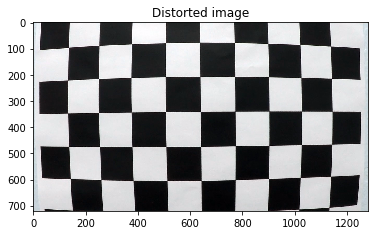

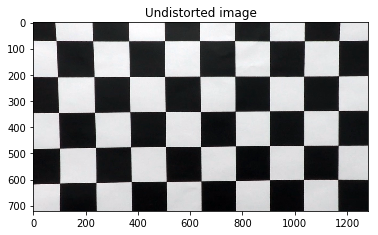

In [2]:
ret = None
mtx = None
dist = None
rvecs = None
tvecs = None

# create undistorting function that uses above object points and imagepoints
def cal_undistort(img_p, objpoints_p, imgpoints_p):
    img = cv2.cvtColor(img_p, cv2.COLOR_RGB2GRAY)
    ret_p, mtx_p, dist_p, rvecs_p, tvecs_p = cv2.calibrateCamera(objpoints_p, imgpoints_p, img_p.shape[1:], None, None)
    ret = ret_p
    mtx  = mtx_p
    dist = dist_p
    rvecs = rvecs_p
    tvecs = tvecs_p
    undist = cv2.undistort(img_p, mtx_p, dist_p, None, mtx_p)
    return undist

# pick a sample image and undistort
filename = 'calibration1.jpg'
img = cv2.imread('camera_cal/'+filename)
plt.title("Distorted image")
plt.imshow(img)
plt.show()
undistored = cal_undistort(img, objpoints, imgpoints)
plt.imshow(undistored)
plt.title("Undistorted image")
plt.savefig('output_images/undistored_'+filename)
plt.show()
        

### Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.


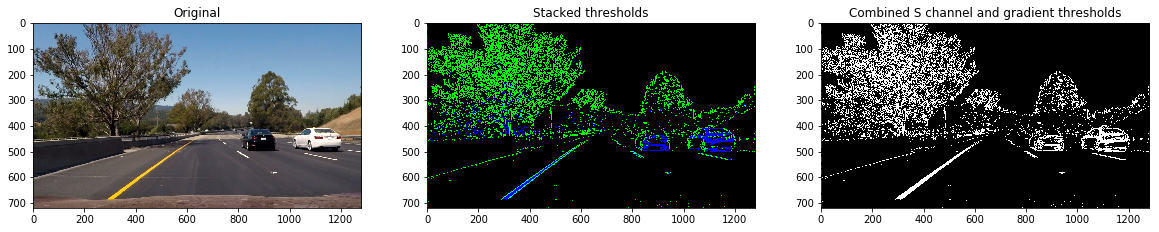

In [58]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



def cal_threshold_binary_image(img, grad_thresh=(0, 255), color_thresh=(0,255)):
#     print ("called threshold_binary_image "+ str(image.shape))
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = grad_thresh[0]#20
    thresh_max =  grad_thresh[1]#100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = color_thresh[0]#170
    s_thresh_max = color_thresh[1]#255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1    
    return color_binary, combined_binary

filename = "test6.jpg"
image = mpimg.imread('test_images/'+filename)
color_binary, combined_binary = cal_threshold_binary_image(image, grad_thresh=(20,100), color_thresh=(170,255))

# Plotting thresholded images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(image)

ax2.set_title('Stacked thresholds')
ax2.imshow(color_binary)

ax3.set_title('Combined S channel and gradient thresholds')
ax3.imshow(combined_binary, cmap='gray')
plt.imsave('output_images/threshold_binary_'+filename, combined_binary,cmap='gray')



### Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

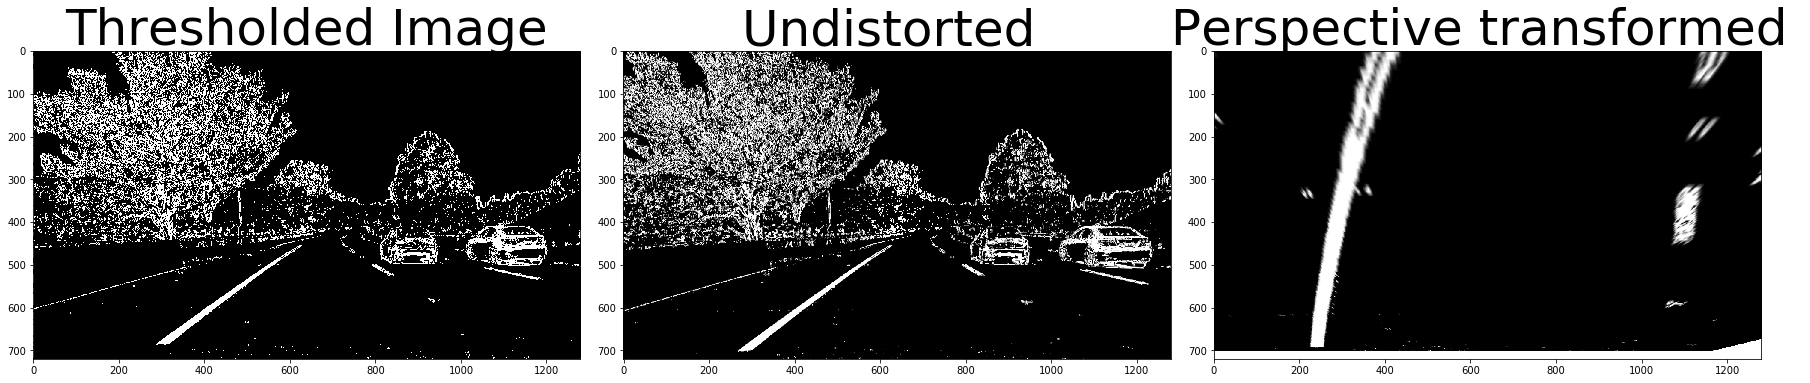

In [4]:
def undistort_and_birds_eye_transform(img):        
    undistored = cal_undistort(img, objpoints, imgpoints)    
    img_size = (undistored.shape[1], undistored.shape[0])

    src = np.float32([[568, 468], [715, 468], [1040, 680], [270, 680]])
    dst = np.float32([[200, 0], [1000, 0], [1000, 680], [200, 680]])
   
    M = cv2.getPerspectiveTransform(src, dst)
    birds_eye_transformed = cv2.warpPerspective(undistored, M, img_size, flags = cv2.INTER_LINEAR)    
    return undistored, birds_eye_transformed

# # filename = "straight_lines1.jpg"
# # image = mpimg.imread('../test_images/'+filename)
filename = "test6.jpg"
threshold_binary_image = mpimg.imread('output_images/threshold_binary_'+filename)


# filename = "test6.jpg"
# image = mpimg.imread('test_images/'+filename)
undistored, birds_eye_transformed = undistort_and_birds_eye_transform(threshold_binary_image)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(threshold_binary_image)
ax1.set_title('Thresholded Image', fontsize=50)

ax2.imshow(undistored)
ax2.set_title('Undistorted ', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.imshow(birds_eye_transformed)
ax3.set_title('Perspective transformed ', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# drop unnecessary channels
birds_eye_transformed = birds_eye_transformed[:,:,0]
plt.imsave('output_images/threshold_binary_birds_eye_transformed_'+filename, birds_eye_transformed,cmap='gray')


### Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

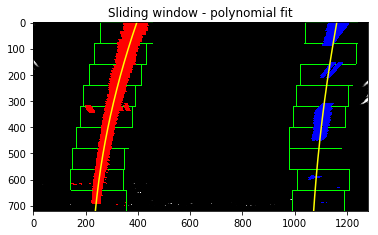

In [5]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
filename = "test6.jpg"
threshold_binary_birds_eye_transformed = mpimg.imread('output_images/threshold_binary_birds_eye_transformed_'+filename)

def find_lane_pixels(birds_eye_image):
    
    birds_eye_image = cv2.cvtColor(birds_eye_image, cv2.COLOR_RGB2GRAY)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(birds_eye_image[birds_eye_image.shape[0]//2:,:], axis=0)   
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((birds_eye_image, birds_eye_image, birds_eye_image))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(birds_eye_image.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birds_eye_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = birds_eye_image.shape[0] - (window+1)*window_height
        win_y_high = birds_eye_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

left_fitx_result = None
right_fit_result = None

def fit_polynomial(birds_eye_image):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(birds_eye_image)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, birds_eye_image.shape[0]-1, birds_eye_image.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines

            
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

# plt.imshow(threshold_binary_birds_eye_transformed)
sliding_window_poly_fit, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(threshold_binary_birds_eye_transformed)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title("Sliding window - polynomial fit")
plt.imshow(sliding_window_poly_fit)

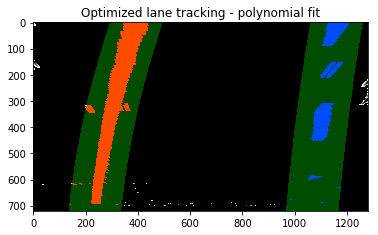

In [6]:
# Load our image
filename = "test6.jpg"
threshold_binary_birds_eye_transformed = mpimg.imread('output_images/threshold_binary_birds_eye_transformed_'+filename)


# binary_warped = mpimg.imread('../output_images/threshold_binary_warped_threshold_binary_test6.jpg')
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(birds_eye_img):
    birds_eye_img = cv2.cvtColor(birds_eye_img, cv2.COLOR_RGB2GRAY)
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = birds_eye_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(birds_eye_img.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((birds_eye_img, birds_eye_img, birds_eye_img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
 
    ## End visualization steps ##
    
    return result, ploty, left_fit, right_fit

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, ploty, left_fit, right_fit = search_around_poly(threshold_binary_birds_eye_transformed)

# View your output
plt.imshow(result)
# # Plot the polynomial lines onto the image
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
plt.title("Optimized lane tracking - polynomial fit")
plt.imsave('output_images/threshold_binary_warped_optimized_'+filename, result,cmap='gray')

### Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [7]:
def measure_curvature_pixels(left_fit_p, right_fit_p):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curve = ((1 + (2*left_fit_p[0]*y_eval + left_fit_p[1])**2)**1.5) / np.absolute(2*left_fit_p[0])
    right_curve = ((1 + (2*right_fit_p[0]*y_eval + right_fit_p[1])**2)**1.5) / np.absolute(2*right_fit_p[0])
    
    return left_curve, right_curve


# Calculate the radius of curvature in pixels for both lane lines
left_curve, right_curve = measure_curvature_pixels(left_fit, right_fit)
print(left_curve, 'pixels', right_curve, 'pixels')

###############################################################################################

def fit_poly_real(img_shape, leftx, lefty, rightx, righty):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit_cr, right_fit_cr, ploty

def search_around_poly_real(birds_eye_img):
    birds_eye_img = cv2.cvtColor(birds_eye_img, cv2.COLOR_RGB2GRAY)
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = birds_eye_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit_cr, right_fit_cr, ploty = fit_poly_real(birds_eye_img.shape, leftx, lefty, rightx, righty)   
    
    return left_fit_cr, right_fit_cr, ploty

def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

#Run image through the pipeline
left_fit_cr, right_fit_cr, ploty = search_around_poly_real(threshold_binary_birds_eye_transformed)
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')



2947.34994402 pixels 6356.95689772 pixels
1009.56506333 m 2899.6820968 m


### Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

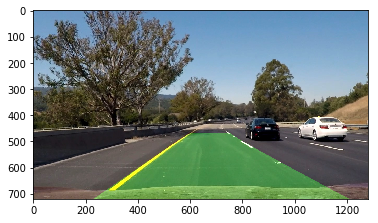

In [8]:

filename = "test6.jpg"
original_image = mpimg.imread('test_images/'+filename)

def distort_and_revert_transformed(img):       
    undistored = cal_undistort(img, objpoints, imgpoints)    
    img_size = (undistored.shape[1], undistored.shape[0])
    src = np.float32([[200, 0], [1000, 0], [1000, 680], [200, 680]])
    dst = np.float32([[568, 468], [715, 468], [1040, 680], [270, 680]])
    M = cv2.getPerspectiveTransform(src, dst)
    revert_transformed= cv2.warpPerspective(undistored, M, img_size, flags = cv2.INTER_LINEAR)    
    return undistored, revert_transformed


threshold_binary_birds_eye_transformed = mpimg.imread('output_images/threshold_binary_birds_eye_transformed_'+filename)


mask_img = np.zeros_like(threshold_binary_birds_eye_transformed[:,:,0]).astype(np.uint8) 
color_mask = np.dstack((mask_img, mask_img, mask_img)) 
# Recast the x and y points into usable format for cv2.fillPoly() 
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))]) 
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]) 
pts = np.hstack((pts_left, pts_right)) 
# Draw the lane onto the warped blank image 

cv2.fillPoly(color_mask, np.int_([pts]), (0,255, 0)) 
# Warp the blank back to original image space using inverse perspective matrix (Minv) 
undistored, revert_transformed = distort_and_revert_transformed(color_mask)
# # Combine the result with the original image 
result = cv2.addWeighted(original_image, 1, revert_transformed, 0.3, 0) 
plt.imshow(result)
plt.imsave('output_images/lane_plotted_'+filename, image,cmap='gray')

### Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def processImage(img_p, mtx_p, dist_p) :    
#     type(img_p)
    undistorted_image = cv2.undistort(img_p, mtx_p, dist_p, None, mtx_p)
    color_binary, combined_binary = cal_threshold_binary_image(undistorted_image, grad_thresh=(20,100), color_thresh=(170,255))
    
    img_size = (color_binary.shape[1], color_binary.shape[0])

    src = np.float32([[568, 468], [715, 468], [1040, 680], [270, 680]])
    dst = np.float32([[200, 0], [1000, 0], [1000, 680], [200, 680]])
   
    M = cv2.getPerspectiveTransform(src, dst)
    birds_eye_transformed = cv2.warpPerspective(color_binary, M, img_size, flags = cv2.INTER_LINEAR)    

    sliding_window_poly_fit, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(birds_eye_transformed)
    result, ploty, left_fit, right_fit = search_around_poly(birds_eye_transformed)
    
    mask_img = np.zeros_like(birds_eye_transformed[:,:,0]).astype(np.uint8) 
    color_mask = np.dstack((mask_img, mask_img, mask_img)) 
    # Recast the x and y points into usable format for cv2.fillPoly() 
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))]) 
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]) 
    pts = np.hstack((pts_left, pts_right)) 
    # Draw the lane onto the warped blank image 

    cv2.fillPoly(color_mask, np.int_([pts]), (0,255, 0)) 
    # Warp the blank back to original image space using inverse perspective matrix (Minv) 
    undistored, revert_transformed = distort_and_revert_transformed(color_mask)
    result = cv2.addWeighted(img_p, 1, revert_transformed, 0.3, 0) 
    return result


project_output = 'output_images/project_output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

objpoints, imgpoints = calibrate_camera()

clip3 = VideoFileClip('project_video.mp4').subclip(0,2)
# clip3 = VideoFileClip('project_video.mp4')

# calibrate using checker board images
objpoints, imgpoints = calibrate_camera()
ret_p, mtx_p, dist_p, rvecs_p, tvecs_p = cv2.calibrateCamera(objpoints, imgpoints, image.shape[1:], None, None)


challenge_clip = clip3.fl_image(lambda image: processImage(image, mtx_p, dist_p)) 
%time challenge_clip.write_videofile(project_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video output_images/project_output_video.mp4
[MoviePy] Writing video output_images/project_output_video.mp4



 98%|█████████▊| 50/51 [01:14<00:01,  1.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output_video.mp4 

CPU times: user 1min 12s, sys: 415 ms, total: 1min 12s
Wall time: 1min 17s


In [66]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def processImage(img_p, mtx_p, dist_p) :    
#     type(img_p)
    undistorted_image = cv2.undistort(img_p, mtx_p, dist_p, None, mtx_p)
    color_binary, combined_binary = cal_threshold_binary_image(undistorted_image, grad_thresh=(20,100), color_thresh=(170,255))
#     pad = np.zeros((combined_binary.shape[0], combined_binary.shape[1]))
#     combined_binary = np.stack((combined_binary, pad, pad), axis=-1)
#     plt.imshow(result)(combined_binary)
    combined_binary = cv2.cvtColor(combined_binary, cv2.COLOR_GRAY2BGR)  
    img_size = (combined_binary.shape[1], combined_binary.shape[0])

    src = np.float32([[568, 468], [715, 468], [1040, 680], [270, 680]])
    dst = np.float32([[200, 0], [1000, 0], [1000, 680], [200, 680]])

    M = cv2.getPerspectiveTransform(src, dst)
    birds_eye_transformed = cv2.warpPerspective(combined_binary, M, img_size, flags = cv2.INTER_LINEAR)    

    sliding_window_poly_fit, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(birds_eye_transformed)
    result, ploty, left_fit, right_fit = search_around_poly(birds_eye_transformed)

    mask_img = np.zeros_like(birds_eye_transformed[:,:,0]).astype(np.uint8) 
    color_mask = np.dstack((mask_img, mask_img, mask_img)) 
    # Recast the x and y points into usable format for cv2.fillPoly() 
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))]) 
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]) 
    pts = np.hstack((pts_left, pts_right)) 
    # Draw the lane onto the warped blank image 

    cv2.fillPoly(color_mask, np.int_([pts]), (0,255, 0)) 
    # Warp the blank back to original image space using inverse perspective matrix (Minv) 
    undistored, revert_transformed = distort_and_revert_transformed(color_mask)
    result = cv2.addWeighted(img_p, 1, revert_transformed, 0.3, 0) 
    return result


project_output = 'output_images/project_output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

objpoints, imgpoints = calibrate_camera()

# clip3 = VideoFileClip('project_video.mp4').subclip(0,2)
clip3 = VideoFileClip('project_video.mp4')

# calibrate using checker board images
objpoints, imgpoints = calibrate_camera()
ret_p, mtx_p, dist_p, rvecs_p, tvecs_p = cv2.calibrateCamera(objpoints, imgpoints, image.shape[1:], None, None)


challenge_clip = clip3.fl_image(lambda image: processImage(image, mtx_p, dist_p)) 
%time challenge_clip.write_videofile(project_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video output_images/project_output_video.mp4
[MoviePy] Writing video output_images/project_output_video.mp4


  3%|▎         | 44/1261 [01:05<32:06,  1.58s/it]

KeyboardInterrupt: 

In [69]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def processImage(img_p, mtx_p, dist_p) :    
#     type(img_p)
    undistorted_image = cv2.undistort(img_p, mtx_p, dist_p, None, mtx_p)
    color_binary, combined_binary = cal_threshold_binary_image(undistorted_image, grad_thresh=(20,100), color_thresh=(170,255))
#     pad = np.zeros((combined_binary.shape[0], combined_binary.shape[1]))
#     combined_binary = np.stack((combined_binary, pad, pad), axis=-1)
#     plt.imshow(result)(combined_binary)
    combined_binary = cv2.cvtColor(combined_binary, cv2.COLOR_GRAY2BGR)  
    img_size = (combined_binary.shape[1], combined_binary.shape[0])

    src = np.float32([[568, 468], [715, 468], [1040, 680], [270, 680]])
    dst = np.float32([[200, 0], [1000, 0], [1000, 680], [200, 680]])

    M = cv2.getPerspectiveTransform(src, dst)
    birds_eye_transformed = cv2.warpPerspective(combined_binary, M, img_size, flags = cv2.INTER_LINEAR)    

    sliding_window_poly_fit, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(birds_eye_transformed)
    result, ploty, left_fit, right_fit = search_around_poly(birds_eye_transformed)

    mask_img = np.zeros_like(birds_eye_transformed[:,:,0]).astype(np.uint8) 
    color_mask = np.dstack((mask_img, mask_img, mask_img)) 
    # Recast the x and y points into usable format for cv2.fillPoly() 
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))]) 
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]) 
    pts = np.hstack((pts_left, pts_right)) 
    # Draw the lane onto the warped blank image 

    cv2.fillPoly(color_mask, np.int_([pts]), (0,255, 0)) 
    # Warp the blank back to original image space using inverse perspective matrix (Minv) 
    undistored, revert_transformed = distort_and_revert_transformed(color_mask)
    result = cv2.addWeighted(img_p, 1, revert_transformed, 0.3, 0) 
    return result


project_output = 'output_images/harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

objpoints, imgpoints = calibrate_camera()

# clip3 = VideoFileClip('harder_challenge_video.mp4')
clip3 = VideoFileClip('harder_challenge_video.mp4').subclip(0,2)

# calibrate using checker board images
objpoints, imgpoints = calibrate_camera()
ret_p, mtx_p, dist_p, rvecs_p, tvecs_p = cv2.calibrateCamera(objpoints, imgpoints, image.shape[1:], None, None)


challenge_clip = clip3.fl_image(lambda image: processImage(image, mtx_p, dist_p)) 
%time challenge_clip.write_videofile(project_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video output_images/harder_challenge_video_output.mp4
[MoviePy] Writing video output_images/harder_challenge_video_output.mp4



 98%|█████████▊| 50/51 [01:16<00:01,  1.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video_output.mp4 

CPU times: user 1min 12s, sys: 184 ms, total: 1min 12s
Wall time: 1min 19s
